In [2]:
%matplotlib inline
from astLib.astCoords import decimal2dms, decimal2hms, hms2decimal, dms2decimal
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.cosmology import Planck15
from astropy.io import ascii, fits
from astropy.table import Column, Table, join, vstack
from cartopy import crs
from matplotlib import pyplot as plt, ticker
import numpy as np

# my own code
from astro.clusters import catalogs, conversions
from plottery.plotutils import savefig, update_rcParams
update_rcParams()

/home/cristobal/anaconda3/envs/astroconda/lib/python3.6/site-packages/plottery/plotutils.py:175: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  rcParams[key] = default[key]


# Load catalogs
Remember than Planck masses are not calibrated

In [3]:
actcols = ('name', 'RADeg', 'decDeg', 'redshift',
           'M500cCal', 'M500cCal_errMinus', 'M500cCal_errPlus')
pszcols = ('NAME', 'RA', 'DEC', 'REDSHIFT',
           'MSZ', 'MSZ_ERR_LOW', 'MSZ_ERR_UP')
colnames = ('name', 'ra', 'dec', 'z', 'm500', 'm500lo', 'm500hi')
#actcols, pszcols = [{key: name for key, name in zip(colnames, cols)}
                    #for cols in (actcols, pszcols)]

In [4]:
psz = catalogs.load('psz2')
psz.rename_columns(pszcols, colnames)
for col in ('m500','m500lo','m500hi'):
    psz[col] /= 0.8
psz.sort('m500', reverse=True)

In [5]:
act = Table(fits.getdata('../../catalogs/actpol/dr5/DR5_cluster-catalog_v1.1.fits'))
act.rename_columns(actcols, colnames)
act.sort('m500', reverse=True)

Apply footprint masks

In [6]:
cats = [act, psz]
for i, (cat, cols) in enumerate(zip(cats, (actcols, pszcols))):
    for key in ('z','m500','m500lo','m500hi','SNR'):
        cat[key].format = '%.2f'
    for key in ('ra','dec'):
        cat[key].format = '%.6f'
    cat['hms'] = [decimal2hms(ra, ':')[:-2] for ra in cat['ra']]
    cat['dms'] = [decimal2dms(dec, ':')[:-3] for dec in cat['dec']]
    cat['coords'] = SkyCoord(ra=cat['ra']*u.deg, dec=cat['dec']*u.deg)
    gal = cat['coords'].transform_to('galactic')
    cat['l'] = gal.l
    cat['b'] = gal.b
    mask = (cat['l'] > 180*u.deg) & (np.abs(cat['b']) > 10*u.deg) \
        & (cat['dec'] > -80) & (cat['dec'] < 5) & (cat['z'] < 0.6)
    cats[i] = cat[mask]
    print(mask.sum())
act, psz = cats
# for later use
psz.add_column(np.arange(psz['name'].size, dtype=int), name='index')
act.add_column(np.arange(act['name'].size, dtype=int), name='index')

1090
613


So there are 1,090 and 613 clusters within the allowed region of the sky in the ACT and PSZ catalogues, respectively.

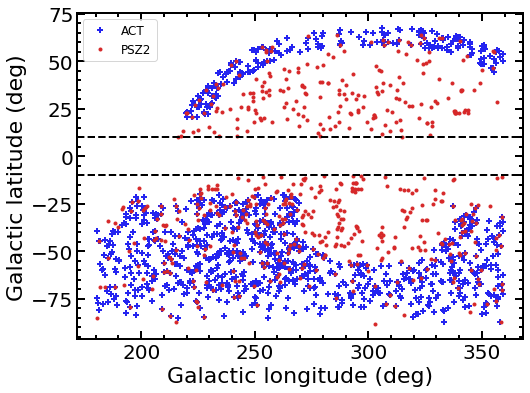

In [7]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(act['l'], act['b'], '+', mew=2, label='ACT')
ax.plot(psz['l'], psz['b'], 'C3.', label='PSZ2')
ax.axhline(-10, ls='--', color='k')
ax.axhline(10, ls='--', color='k')
ax.set(xlabel='Galactic longitude (deg)', ylabel='Galactic latitude (deg)')
ax.legend(loc='upper left', fontsize=12)

Let's match both catalogues

In [8]:
dist = psz['coords'].separation(act['coords'][:,None])
act_in_psz = np.argmin(dist, axis=0)
psz_in_act = np.argmin(dist, axis=1)
dist.shape

(1090, 613)

using a $10'$ radius. Being generous here since we'll be observing large areas of the sky for each cluster

In [9]:
matchdist = 10*u.arcmin
act_in_psz_dist = np.min(dist, axis=0)
psz_in_act_dist = np.min(dist, axis=1)
act_in_psz_match = (act_in_psz_dist < matchdist)
psz_in_act_match = (psz_in_act_dist < matchdist)
act_in_psz_match.size, act_in_psz_match.sum(), psz_in_act_match.sum()

(613, 172, 181)

170-180 objects in common. The reason why the numbers are different is that many ACT clusters can coincide with a single PSZ2 source at these separations (also many may not be at the same redshift - we kind of need to control for that). Let's store cross indices and masses for easy access

In [10]:
act['PSZ_index'] = psz_in_act
act['PSZ_index'][~psz_in_act_match] = -99
act['PSZ_separation'] = psz_in_act_match
act['PSZ_name'] = psz['name'][psz_in_act]
act['PSZ_name'][~psz_in_act_match] = '--'
act['PSZ_m500'] = psz['m500'][psz_in_act]
act['PSZ_m500'][~psz_in_act_match] = -99

psz['ACT_index'] = act_in_psz
psz['ACT_index'][~act_in_psz_match] = -99
psz['ACT_sepatation'] = act_in_psz_match
psz['ACT_name'] = act['name'][act_in_psz]
psz['ACT_name'][~act_in_psz_match] = '--'
psz['ACT_m500'] = act['m500'][act_in_psz]
psz['ACT_m500'][~act_in_psz_match] = -99

# Low-redshift sample

Find a maximum ``Nlowz`` clusters in the low-z redshift range

In [11]:
lowzrng = (0.03, 0.07)
Nlowz = 60

In [12]:
psz_lowz = (psz['z'] >= lowzrng[0]) & (psz['z'] <= lowzrng[1])
psz_lowz.sum()

46

So there are 46 clusters in this redshift range in PSZ2.

In [13]:
np.array(psz['m500'][psz_lowz])

array([9.924268 , 8.794818 , 8.567452 , 8.296242 , 5.9826775, 5.784614 ,
       5.280762 , 4.610898 , 4.38343  , 4.3160686, 4.055727 , 4.0151234,
       3.6103845, 3.5868728, 3.522874 , 3.3923566, 3.2232826, 3.1020849,
       3.085899 , 3.0537498, 2.9929283, 2.9798045, 2.8788261, 2.8154902,
       2.6500714, 2.573958 , 2.397276 , 2.3049746, 2.3005235, 2.295922 ,
       2.259935 , 2.2526896, 2.2520623, 2.2248826, 2.1930475, 2.1332328,
       2.128055 , 2.0829904, 1.9333471, 1.9178876, 1.9135951, 1.8982316,
       1.895306 , 1.8304377, 1.8183829, 1.4084238], dtype=float32)

Are there ACT clusters in this redshift range?

In [14]:
act_lowz = (act['z'] >= lowzrng[0]) & (act['z'] <= lowzrng[1])
act_lowz.sum()

6

In [15]:
act['name','z','m500','SNR'][act_lowz]

name,z,m500,SNR
str19,float64,float64,float64
ACT-CL J0507.6-0915,0.04,7.30,4.92
ACT-CL J0600.7-5836,0.04,5.67,4.98
ACT-CL J2012.4-5649,0.06,5.67,7.23
ACT-CL J0342.9-5337,0.06,4.53,5.53
ACT-CL J2357.0-3445,0.05,4.26,7.02
ACT-CL J2313.9-4243,0.06,3.39,5.20


These are A3158, A536, A560, A3667, AS1101, A4059, in that order.

Are they in PSZ?

In [16]:
d = act['coords'][act_lowz].separation(psz['coords'][psz_lowz][:,None])
closest = np.min(d, axis=0)
closest

<Angle [9.26672257, 4.90625453, 0.02193704, 0.03347553, 0.03602238,
        0.05791278] deg>

So it appears that 4 of them are; A536 and A560 seem to be missing (they are also the two lowest-SNR in ACT in this redshift range, though not the two lowest mass). Let's include them in the sample since anyway we are below the 50 clusters mark with PSZ alone.

### Store full catalogue

Merged PSZ+ACT table. If a cluster is present in both PSZ2 and ACT, the first columns contain the PSZ name and the ACT coordinates, redshift and mass.

In [39]:
act_lowz_tbl = act['index','name','hms','dms','z','m500','m500lo','m500hi','PSZ_name'][act_lowz]
act_lowz_tbl.rename_columns(('name','PSZ_name'), ('ACT_name','name'))
lowz = join(psz['index','name','hms','dms','z','m500','m500lo','m500hi'][psz_lowz],
            act_lowz_tbl, keys=('name',), join_type='outer', table_names=('PSZ','ACT'))
lowz['name'] = [name if name != '--' else act_name for name, act_name in lowz['name','ACT_name']]
lowz.add_column(np.arange(lowz['name'].size, dtype=int), name='index', index=0)
for col in ('hms','dms','z','m500','m500lo','m500hi')[::-1]:
    lowz.add_column(
        [psz_val if act_mask else act_val
         for (psz_val, act_val), (psz_mask, act_mask)
         in zip(lowz[f'{col}_PSZ',f'{col}_ACT'], lowz[f'{col}_PSZ',f'{col}_ACT'].mask)],
        name=col, index=1)
for col in ('m500','m500lo','m500hi'):
    lowz[col].format = '%.2f'
lowz['z'].format = '%.3f'
lowz.write('catalogues/chances_clusters_lowz_psz2_plus_act.txt',
           format='ascii.fixed_width', overwrite=True)
lowz

index,hms,dms,z,m500,m500lo,m500hi,index_PSZ,name,hms_PSZ,dms_PSZ,z_PSZ,m500_PSZ,m500lo_PSZ,m500hi_PSZ,index_ACT,ACT_name,hms_ACT,dms_ACT,z_ACT,m500_ACT,m500lo_ACT,m500hi_ACT
int64,str10,str9,float64,float64,float64,float64,int64,str19,str10,str9,float32,float32,float32,float32,int64,str19,str10,str9,float64,float64,float64,float64
0,05:07:38.5,-09:15:27,0.040,7.30,2.26,3.12,--,ACT-CL J0507.6-0915,--,--,--,--,--,--,54,ACT-CL J0507.6-0915,05:07:38.5,-09:15:27,0.04,7.30,2.26,3.12
1,06:00:45.3,-58:36:32,0.037,5.67,1.72,2.35,--,ACT-CL J0600.7-5836,--,--,--,--,--,--,129,ACT-CL J0600.7-5836,06:00:45.3,-58:36:32,0.04,5.67,1.72,2.35
2,04:33:30.3,-13:14:21,0.033,3.39,0.19,0.18,312,PSZ2 G209.54-36.50,04:33:30.3,-13:14:21,0.03,3.39,0.19,0.18,--,--,--,--,--,--,--,--
3,04:38:35.0,-22:06:13,0.067,2.99,0.31,0.29,327,PSZ2 G220.53-38.55,04:38:35.0,-22:06:13,0.07,2.99,0.31,0.29,--,--,--,--,--,--,--,--
4,03:11:28.1,-26:56:09,0.068,2.40,0.35,0.32,354,PSZ2 G220.74-58.91,03:11:28.1,-26:56:09,0.07,2.40,0.35,0.32,--,--,--,--,--,--,--,--
5,05:48:38.6,-25:28:59,0.042,1.91,0.21,0.20,370,PSZ2 G230.28-24.42,05:48:38.6,-25:28:59,0.04,1.91,0.21,0.20,--,--,--,--,--,--,--,--
6,04:08:23.0,-30:59:28,0.060,2.30,0.23,0.22,355,PSZ2 G230.29-47.13,04:08:23.0,-30:59:28,0.06,2.30,0.23,0.22,--,--,--,--,--,--,--,--
7,09:08:56.1,-09:40:20,0.054,8.57,0.16,0.16,50,PSZ2 G239.29+24.75,09:08:56.1,-09:40:20,0.05,8.57,0.16,0.16,--,--,--,--,--,--,--,--
8,04:13:58.7,-38:06:45,0.050,1.90,0.22,0.20,371,PSZ2 G240.80-46.51,04:13:58.7,-38:06:45,0.05,1.90,0.22,0.20,--,--,--,--,--,--,--,--


## Load Chris' sample

(Only looking at the low-z redshift range)

In [19]:
lowz0 = ascii.read('CHANCES low-z clusters - WINGS_CHANCES.csv')
lowz0.rename_columns(
    ('Cluster Name', 'RA_J2000', 'Dec_J2000', 'Z'),
    ('name','ra','dec','z'))
lowz0 = lowz0[lowz0['z'] > 0.03]
lowz0

name,ra,dec,z,Gal_Long,Gal_Latitude,Lx,VST,AAO_redshifts,SPLUS,Comments
str7,float64,float64,float64,float64,float64,float64,str1,int64,str6,str27
A0500,69.716,-22.1,0.067,220.556,-38.49,0.72,Y,478,2020B,--
A0548b,86.366,-25.916,0.044,230.469,-25.248,0.15,N,0,2021B,--
A0754,137.133,-9.616,0.054,239.185,24.707,4.08,Y,423,2021B,--
A0780,139.525,-12.083,0.057,242.915,25.101,3.38,N,0,2021B,--
A0957,153.408,0.916,0.045,240.931,43.981,0.4,Y,154,SPLUS,--
A0970,154.391,-10.666,0.059,253.075,36.897,0.77,Y,136,SPLUS,--
A1069,159.929,-8.683,0.062,256.585,42.035,0.48,Y,496,SPLUS,--
A1631a,193.216,-15.4,0.047,303.441,47.47,0.37,Y,673,SPLUS,--
A1644,194.295,-17.4,0.048,304.885,45.449,1.8,N,0,SPLUS,--


Match to the PSZ+ACT catalogue

In [20]:
lowz0_coords = SkyCoord(ra=lowz0['ra'], dec=lowz0['dec'], unit='deg', frame='icrs')
coords = SkyCoord([f'{hms} {dms}' for hms, dms in lowz['hms','dms']],
                  frame='icrs', unit=(u.hourangle, u.deg))
sep = lowz0_coords.separation(coords[:,None])
minsep = np.min(sep, axis=0)
jminsep = np.argmin(sep, axis=0)
minsep

<Angle [6.51108081e-02, 8.36893295e-01, 1.14134213e-01, 3.29755438e+00,
        1.87741778e+00, 6.93609988e-02, 6.93562544e-02, 1.14236056e-01,
        2.39242874e-02, 5.49771881e-02, 1.72869647e+00, 2.20228131e+00,
        3.35011754e-02, 6.42067981e-02, 4.31264030e-02, 2.01437119e-01,
        6.64757147e-02, 1.43249236e-02, 6.96000460e-02, 2.21070196e-01,
        3.35783013e-01, 3.81906523e-01, 1.69917256e-02, 8.35310369e-01,
        2.99282660e-02, 1.56153829e+00, 5.52038614e-02, 1.48586165e-02,
        1.62157609e-01, 4.72692950e-02, 5.24624751e-03, 4.76814160e-03,
        1.20280702e-02, 7.34935989e+00, 8.46243988e+00, 1.38512110e-02,
        1.00210448e-01, 1.08157872e-02, 2.56745821e-02, 3.83743868e-02] deg>

What sorts of areas will we really be observing? Let's say these clusters have $M_{200}\sim10^{14}\,\mathrm{M}_\odot$. Then,

In [21]:
r200 = conversions.rsph(1e14, np.array([0.03, 0.07]))
r200

array([0.94879332, 0.93688437])

About a Mpc. Let's now say we observe 3 times $r_{200}$,

In [22]:
(3*u.Mpc / Planck15.kpc_proper_per_arcmin([0.03,0.07])).to(u.arcmin)

<Quantity [80.57189307, 36.21609972] arcmin>

so at least half a degree. Let's take half that, $15'$:

In [23]:
lowz_match_dist = 15 * u.arcmin
matches = (minsep < lowz_match_dist)
matches.sum()

29

29 ACT+PSZ clusters that would be observed if we only observed the original CHANCES sample (I'm reluctant to call them "matches" -- note that the number of overlapping clusters does not increase much for larger separations: there are only 31 overlapping ACT+PSZ clusters if we increase the separation to $30'$.)

In [24]:
lowz0['PSZ_name'] = [lowz['name'][jminsep[i]] if matches[i] else '--' for i in range(lowz0['name'].size)]
lowz0['name','PSZ_name']

name,PSZ_name
str7,str18
A0500,PSZ2 G220.53-38.55
A0548b,--
A0754,PSZ2 G239.29+24.75
A0780,--
A0957,--
A0970,PSZ2 G253.04+36.83
A1069,PSZ2 G256.67+42.05
A1631a,PSZ2 G303.56+47.54
A1644,PSZ2 G304.91+45.43


In [25]:
minsep_psz = np.min(sep, axis=1)
jminsep_psz = np.argmin(sep, axis=1) # size 48
np.unique(jminsep_psz[minsep_psz < lowz_match_dist]).size

29

i.e., these are unique matches. Our low-z candidates catalogue therefore contains 48 + (40-29) = 59 clusters.

In [40]:
lowz_all = vstack([lowz0, lowz[minsep_psz > lowz_match_dist]])
n = lowz_all['name'].size
lowz_all['PSZ_name'] = [row['name'] if row['name'][:4] == 'PSZ2' else row['PSZ_name'] for row in lowz_all]
lowz_all = lowz_all[lowz_all.colnames[:18]]
lowz_all.remove_column('index')
lowz_all.add_column(np.arange(lowz_all['name'].size, dtype=int), name='index', index=0)
lowz_all_coords = [SkyCoord(ra=row['ra'], dec=row['dec'], unit='deg', frame='icrs')
                   if not mask['ra']
                   else SkyCoord(f"{row['hms']} {row['dms']}", unit=(u.hourangle, u.deg), frame='icrs')
                   for (row, mask) in zip(lowz_all, lowz_all.mask)]
lowz_all['ra'] = [i.ra.deg for i in lowz_all_coords]
lowz_all['dec'] = [i.dec.deg for i in lowz_all_coords]
lowz_all['ra'].format = '%.6f'
lowz_all['dec'].format = '%.5f'
lowz_all['hms'] = [i.ra.to(u.hourangle).to_string(sep=':') for i in lowz_all_coords]
lowz_all['dms'] = [i.dec.to(u.deg).to_string(sep=':') for i in lowz_all_coords]
lowz_all.write('catalogues/chances_clusters_lowz_all.txt',
               format='ascii.fixed_width', overwrite=True)
lowz_all

index,name,ra,dec,z,Gal_Long,Gal_Latitude,Lx,VST,AAO_redshifts,SPLUS,Comments,PSZ_name,hms,dms,m500,m500lo,m500hi
int64,str19,float64,float64,float64,float64,float64,float64,str1,int64,str6,str27,str32,str11,str11,float64,float64,float64
0,A0500,69.716000,-22.10000,0.067,220.556,-38.49,0.72,Y,478,2020B,--,PSZ2 G220.53-38.55,4:38:51.84,-22:06:00,--,--,--
1,A0548b,86.366000,-25.91600,0.044,230.469,-25.248,0.15,N,0,2021B,--,--,5:45:27.84,-25:54:57.6,--,--,--
2,A0754,137.133000,-9.61600,0.054,239.185,24.707,4.08,Y,423,2021B,--,PSZ2 G239.29+24.75,9:08:31.92,-9:36:57.6,--,--,--
3,A0780,139.525000,-12.08300,0.057,242.915,25.101,3.38,N,0,2021B,--,--,9:18:06,-12:04:58.8,--,--,--
4,A0957,153.408000,0.91600,0.045,240.931,43.981,0.4,Y,154,SPLUS,--,--,10:13:37.92,0:54:57.6,--,--,--
5,A0970,154.391000,-10.66600,0.059,253.075,36.897,0.77,Y,136,SPLUS,--,PSZ2 G253.04+36.83,10:17:33.84,-10:39:57.6,--,--,--
6,A1069,159.929000,-8.68300,0.062,256.585,42.035,0.48,Y,496,SPLUS,--,PSZ2 G256.67+42.05,10:39:42.96,-8:40:58.8,--,--,--
7,A1631a,193.216000,-15.40000,0.047,303.441,47.47,0.37,Y,673,SPLUS,--,PSZ2 G303.56+47.54,12:52:51.84,-15:24:00,--,--,--
8,A1644,194.295000,-17.40000,0.048,304.885,45.449,1.8,N,0,SPLUS,--,PSZ2 G304.91+45.43,12:57:10.8,-17:24:00,--,--,--


In [37]:
lowz_all['name'][lowz_all.mask['name']]

<Column name='name' dtype='str18' length=0>

# Evolution sample

In [ ]:
evzrng = (0.07, 0.4)
Nev = 50

In [ ]:
pszev = (psz['z'] > evzrng[0]) & (psz['z'] <= evzrng[1])
pszev.sum()

Now limit by mass

In [ ]:
psz['m500'][pszev][:Nev].data

So $M_{500}>7.85\times10^{14}\,\mathrm{M}_\odot$. Let's define a mask:

In [ ]:
pszev_massive = pszev & (psz['m500'] > 7.85)
pszev_massive.sum()

How many are in ACT?

In [ ]:
actev = (act['z'] > evzrng[0]) & (act['z'] <= evzrng[1])
(act[actev]['PSZ_index'] > -99).sum()

In [ ]:
(psz[pszev_massive]['ACT_index'] > -99).sum()

Only 29 of the `Nev` we selected from PSZ2 are in ACT. How many of the `Nact` most massive ACT clusters are we missing?

In [ ]:
Nact = 50
act['m500'][actev][:Nact].data

So a cut $M_{500}>6.2\times10^{14}\,\mathrm{M}_\odot$ gives us the 50 most massive ACT clusters in the CHANCES-Evolution redshift range.

In [ ]:
actev_massive = actev & (act['m500'] > 6.2)
actev_massive.sum()

In [ ]:
actev_massive_not_in_psz = actev_massive & (act['PSZ_index'] == -99)
actev_massive_not_in_psz.sum()

These are the massive ACT clusters that are not in PSZ2 at all:

In [ ]:
act['name','z','m500'][actev_massive_not_in_psz]

In [ ]:
query = 'sourceList=S18d_202006 and ' \
    + ' and '.join([f'name="{cl}"' for cl in act['name'][actev_massive_not_in_psz]])
query

**Only 6 of the 50 most massive ACT clusters are not in the PSZ2 catalog.** 

Of these 6 it appears only ACT-CL J0138.0-2155 is interesting enough in its own right.


Did all of the others make it in the Evolution sample though?

In [ ]:
actev_massive_in_psz = actev_massive & (act['PSZ_index'] > -99)
psz['name','z','m500','ACT_index','ACT_name'][act['PSZ_index'][actev_massive_in_psz]]

In [ ]:
in_both_massive_samples = \
    np.in1d(psz['name'][act['PSZ_index'][actev_massive_in_psz]], psz['name'][pszev_massive])
psz['name','z','m500'][act['PSZ_index'][actev_massive_in_psz]][in_both_massive_samples]

So of the 44 matches, only 21 appear massive enough in the PSZ2 catalogue to make it into the Evolution sample...

In [ ]:
psz['index','name','hms','dms','z','m500','ACT_index','ACT_name'][act['PSZ_index'][actev_massive_in_psz]][~in_both_massive_samples]

In [ ]:
(psz['z'][act['PSZ_index'][actev_massive_in_psz]][~in_both_massive_samples] == -1).sum()

2 of the 23 missing do not have a redshift (therefore no mass). What are the ACT masses of these 23 clusters?

In [ ]:
tbl = act['index','name','hms','dms','z','m500','PSZ_index','PSZ_name'][actev_massive_in_psz][~in_both_massive_samples]
tbl.write('../act_massive_missing_in_pszev.html', format='ascii.html', delimiter='|', overwrite=True)
tbl

Let's make a query for the ACT database

In [ ]:
query = 'sourceList=S18d_202006 and ' \
    + ' and '.join([f'name="{cl}"' for cl in sorted(act['name'][actev_massive_in_psz][~in_both_massive_samples])])
query

In [ ]:
details_dict = {
    'ACT-CL J0040.8-4407': r"""(*) Strong lensing. <a href="http://ned.ipac.caltech.edu/cgi-bin/objsearch?objname=GALEXASC+J004055.76-441249.2++&extend=no&hconst=73&omegam=0.27&omegav=0.73&corr_z=1&out_csys=Equatorial&out_equinox=J2000.0&obj_sort=RA+or+Longitude&of=pre_text&zv_breaker=30000.0&list_limit=5&img_stamp=YES">QSO at z=1.383 5 arcmin away</a>""",
    'ACT-CL J0042.1-2832': """Abell 2811 <a href="http://ned.ipac.caltech.edu/conesearch?in_csys=Equatorial&in_equinox=J2000&coordinates=10.528810d%20-28.533392d&radius=10&hconst=67.8&omegam=0.308&omegav=0.692&wmap=4&corr_z=1&z_constraint=Unconstrained&z_unit=z&ot_include=ANY&in_objtypes1%5BQSO%5D=QSO&nmp_op=ANY&search_type=Near%20Position%20Search&out_csys=Same%20as%20Input&out_equinox=Same%20as%20Input&obj_sort=Distance%20to%20search%20center">QSOs nearby</a>""",
    'ACT-CL J0114.7-4123': '',    
    'ACT-CL J0118.2-2658': 'Abell 2895. Chandra',
    'ACT-CL J0257.7-2209': 'Abell 402. Chandra',
    'ACT-CL J0304.2-4921': '(*) Strong lensing. 60+ cluster members from ACT follow-up',
    'ACT-CL J0336.2-4037': '',
    'ACT-CL J0347.9-2144': '(*) Fairly rich, multiple big galaxies, strong lensing. PSZ redshift is wrong (Bleem+19)',
    'ACT-CL J0354.5-3745': 'Abell 3184',
    'ACT-CL J0416.1-2404': '(*) MACS J0416.1-2403, CLASH-VLT, Frontier Fields',
    'ACT-CL J0421.3-2022': '(*) Abell S0443, quite rich',
    'ACT-CL J0437.1+0043': '(*) Strong lensing? Chandra',
    'ACT-CL J0520.7-1328': 'Chandra',
    'ACT-CL J0525.8-3035': '',
    'ACT-CL J0525.8-4715': '',
    'ACT-CL J0628.8-4143': 'Abell 3396, no image',
    'ACT-CL J0845.4+0327': """MACS J0845.4+0327. <a href="http://ned.ipac.caltech.edu/cgi-bin/objsearch?objname=SDSS+J084519.53%2B032619.3&extend=no&hconst=73&omegam=0.27&omegav=0.73&corr_z=1&out_csys=Equatorial&out_equinox=J2000.0&obj_sort=RA+or+Longitude&of=pre_text&zv_breaker=30000.0&list_limit=5&img_stamp=YES">QSO at z=1.82 2.6 arcmin away</a>""",
    'ACT-CL J0857.8+0310': 'Abell 732',
    'ACT-CL J0935.2+0048': '(*) Very rich, lots of big galaxies. DECaLS+HSC',
    'ACT-CL J1258.7-0145': """(*) Abell 1650. Chandra. <a href="http://ned.ipac.caltech.edu/cgi-bin/objsearch?objname=2MASS+J12584981-0143032&extend=no&hconst=73&omegam=0.27&omegav=0.73&corr_z=1&out_csys=Equatorial&out_equinox=J2000.0&obj_sort=RA+or+Longitude&of=pre_text&zv_breaker=30000.0&list_limit=5&img_stamp=YES">QSO at z=0.96 3.5 arcmin away</a>""",
    'ACT-CL J1259.3-0410': 'Abell 1651',
    'ACT-CL J1331.1+0100': """<a href="http://ned.ipac.caltech.edu/conesearch?in_csys=Equatorial&in_equinox=J2000&coordinates=202.797559d%20%2B1.005058d&radius=10&hconst=67.8&omegam=0.308&omegav=0.692&wmap=4&corr_z=1&z_constraint=Unconstrained&z_unit=z&ot_include=ANY&in_objtypes1%5BQSO%5D=QSO&nmp_op=ANY&search_type=Near%20Position%20Search&out_csys=Same%20as%20Input&out_equinox=Same%20as%20Input&obj_sort=Distance%20to%20search%20center">Many QSOs nearby</a>""",
    'ACT-CL J2201.8-5956': 'Abell 3827, no image',
    # this one is from the bunch that are not in PSZ at all
    'ACT-CL J0138.0-2155': '(*) impressive red strong lensing arc, fun stuff hapenning around the BCG. Second BCG nearby but SZ contours clearly around the first one'
}
details = [details_dict.get(cl, '') for cl in act['name']]

In [ ]:
if 'details' in act.colnames:
    act['details'] = details
else:
    act.add_column(details, name='details')

In [ ]:
tbl = act['index','name','hms','dms','z','m500','details'][actev_massive_in_psz][~in_both_massive_samples]
tbl.sort('name')
names = [i for i in tbl['name']]
for i, (name, det) in enumerate(tbl['name','details']):
    if det[:3] == '(*)':
        names[i] = f'<b>{name}</b>'
tbl.replace_column('name', names)
tbl.write('act_massive_missing_in_pszev.html', format='ascii.html', delimiter='|', overwrite=True)

In [ ]:
names

These picked out by hand

In [ ]:
act_included = np.in1d(act['name'], [cl for cl, txt in details_dict.items() if txt[:3] == '(*)'])

In [ ]:
act['name','hms','dms','z','m500','PSZ_name'][act_included]

Consider also including the ACT multiple system I like

# Preliminary catalogues

In [ ]:
chances_ev = psz[pszev_massive]
chances_ev['index','name','hms','dms','z','m500','ACT_name','ACT_m500']

In [ ]:
fig, ax = plt.subplots(figsize=(12,10))
with_both_m = (psz['m500'] > 0) & (psz['ACT_m500'] > 0)
ax.scatter(psz['m500'][with_both_m], psz['ACT_m500'][with_both_m], s=80,
           marker='o', facecolors='none', edgecolors='C0', label='All ACT in PSZ')
ax.scatter(psz['m500'][with_both_m & pszev], psz['ACT_m500'][with_both_m & pszev],
           marker='o', c='C0', s=80,
           label=f'ACT in PSZ (${evzrng[0]}<z<{evzrng[1]}$)')
ax.scatter(chances_ev['m500'], chances_ev['ACT_m500'], marker='+', c='C1',
           linewidths=2, s=250, label='ACT in CHANCES-PSZ-Ev')
ax.plot([2,18], [2,18], 'k--')
ax.set(xlim=(2,18), ylim=(2,18), #xscale='log', yscale='log',
       xlabel=r'$M_{500}^\mathrm{PSZ,Cal}\,(10^{14}$M$_\odot$)',
       ylabel=r'$M_{500}^\mathrm{ACT,Cal}\,(10^{14}$M$_\odot$)')
ax.legend()

# CLASH-VLT

In [ ]:
clash="""Abell_383	02:48:06.9	-03:29:32	0.187	Completed
Abell_209       01:31:57.5	-13:34:35	0.209	Completed
RXJ2129+0005	21:29:40.0	00:05:21	0.234	Completed
MS2137-2353	    21:40:12.8  -23:39:27	0.313	Completed
RXJ2248-4431	22:48:54.3	-44:31:07	0.346	Completed
MACSJ1115+01	11:15:53.3	01:29:47	0.352	Completed
MACSJ1931-26	19:31:49.6	-26:34:34	0.352	Completed
MACSJ0416-24	04:16:09.9	-24:03:58	0.396	Completed
MACSJ1206-08	12:06:12.1	-08:48:02	0.440	Completed
MACSJ0329-02	03:29:40.8	-02:11:54	0.450	Completed
RXJ1347-1145	13:47:32.0	-11:45:42	0.451	Completed
MACSJ1311-03	13:11:01.6	-03:10:40	0.494	Completed
MACSJ2129-07	21:29:26.0	-07:41:28	0.570	Completed""".split('\n')
clash = [i.split()[:-1] for i in clash]
clash = [[i[j] for i in clash] for j in range(4)]
clash[3] = np.array(clash[3], dtype=float)
clash = Table(clash, names=('name','hms','dms','z'))
clash['ra'] = [hms2decimal(ra, ':') for ra in clash['hms']]
clash['dec'] = [dms2decimal(dec, ':') for dec in clash['dms']]
clash['ra'].format = '%.6f'
clash['dec'].format = '%.6f'
clash

In [ ]:
clash['coords'] = SkyCoord(ra=clash['ra'], dec=clash['dec'], unit='deg')
clash_sep = clash['coords'].separation(psz['coords'][:,None])
clash_sep.shape

In [ ]:
mindist = np.min(clash_sep, axis=0)
mindist

So only 5 CLASH clusters are in PSZ. Which pass the sky cuts?

In [ ]:
gal = clash['coords'].transform_to('galactic')
clash['l'] = gal.l
clash['b'] = gal.b
clash_chances_mask = (clash['z'] < 0.5) \
    & (clash['l'] > 180*u.deg) & (np.abs(clash['b']) > 10*u.deg) \
    & (clash['dec'] > -80) & (clash['dec'] < 5)
clash_chances_mask

which?

In [ ]:
clash['name','hms','dms','z'][clash_chances_mask]

In [ ]:
from astroquery.ipac.ned import Ned

In [ ]:
help(Ned.get_images)

In [ ]:
from astroquery import image_cutouts
astroquery.__version__

In [ ]:
clash['name','hms','dms','z'][clash_chances_mask & (mindist < 2*u.arcmin)]

Now need to find them in PSZ - do they pass our mass cut?

In [ ]:
clash_psz_matches = np.argmin(clash_sep, axis=0)
psz['name','hms','dms','z','m500'][clash_psz_matches][clash_chances_mask & (mindist < 2*u.arcmin)]

# Plot

Galactic plane

In [ ]:
l = np.linspace(0, 360, 1000)
b = 10*np.ones(l.size)
below_gplane = SkyCoord(l, -b, unit='deg', frame='galactic')
bgp = below_gplane.transform_to('icrs')
above_gplane = SkyCoord(l, b, unit='deg', frame='galactic')
agp = above_gplane.transform_to('icrs')

German sky

In [ ]:
b = np.linspace(-90, 90, 500)
l = np.ones(b.size)
#l = np.append(np.zeros(b.size), 180*np.ones(b.size))
#b = np.append(b, b)
grsplit = SkyCoord(0*l, b, unit='deg', frame='galactic')
gr0 = grsplit.transform_to('icrs')
grsplit = SkyCoord(180*l, b, unit='deg', frame='galactic')
gr180 = grsplit.transform_to('icrs')

for ``fill_between``

In [ ]:
gr_ra = np.append(gr0.ra.deg, gr180.ra.deg)
gr_dec = np.append(gr0.dec.deg, gr180.dec.deg)
jgr = np.argsort(gr_ra)
gr_ra = gr_ra[jgr]
gr_dec = gr_dec[jgr]

In [ ]:
transform = crs.Geodetic()
kwargs = dict(transform=transform)
grcolor = 'k'
fig = plt.figure(figsize=(18,5))
ax = plt.axes(projection=crs.Mollweide())
#ax.plot(gsky.ra.value, gsky.dec.value, 'C1.', **kwargs)
#ax.plot(gsky_ra, gsky_dec, 'C2.', **kwargs)
ax.plot(bgp.ra, bgp.dec, '-', color=grcolor, lw=3, **kwargs)
ax.plot(agp.ra, agp.dec, '-', color=grcolor, lw=3, **kwargs)
# hatch the Galactic plane
bx = np.linspace(-10, 10, 10)
for l in np.linspace(180, 360, 30):
    gl = SkyCoord(l, bx, unit='deg', frame='galactic')
    gl = gl.transform_to('icrs')
    ax.plot(gl.ra.deg, gl.dec.deg, '-', color=grcolor, **kwargs)
ax.fill_between(np.linspace(0, 359.9, 100), 5*np.ones(100), 90*np.ones(100),
                color='C9', alpha=0.6, **kwargs)
#ax.plot([0, 359], [5, 5], 'C2-')
#ax.plot(gr0.ra, gr0.dec, '-', color=grcolor, lw=2, **kwargs)
#ax.plot(gr180.ra, gr180.dec, '-', color=grcolor, lw=2, **kwargs)
ax.fill_between(gr_ra, gr_dec, 90*np.ones(gr_dec.size), color='C5', alpha=0.6, **kwargs)
ax.plot(chances_ev['ra'], chances_ev['dec'], 'C0o', **kwargs, ms=5, label='Base PSZ-Ev')
ax.plot(clash['ra'][clash_chances_mask], clash['dec'][clash_chances_mask],
        'C1+', **kwargs, ms=8, mew=2.5, label='CLASH-VLT')
ax.plot(act['ra'][act_included], act['dec'][act_included], 'C2^',
        **kwargs, ms=6, label='Additional ACT')
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
#ax.set(xlabel='RA (deg)', ylabel='Dec (deg)')
#ax.set_ylim(-90, 90)
ax.legend(loc=(0.20,0.5), framealpha=0.8)

In [ ]:
fig, ax = plt.subplots(figsize=(12,10))
pz = psz[pszcols['z']]
pm = psz[pszcols['m500']]
az = act[actcols['z']]
am = act[actcols['m500']]
pcolor = 'C3'
acolor = 'C0'
ax.plot(pz[~lowz & ~pszev], pm[~lowz & ~pszev], 'o', color=pcolor, label='PSZ2', alpha=0.6)
ax.plot(az [~actev], am[~actev], 'o', color=acolor, label='AdvACT', alpha=0.6)
# low-z
ax.plot(pz[lowz], pm[lowz], 'x', color=pcolor, ms=8, mew=3, label=f'$N_\mathrm{{lowz}}^\mathrm{{PSZ}}={lowz.sum()}$')
# Evolution
ax.plot(pz[pszev], pm[pszev], '+', color=pcolor, ms=8, mew=3, label=f'$N_\mathrm{{ev}}^\mathrm{{PSZ}}={pszev.sum()}$')
ax.plot(az[actev], am[actev], '+', color=acolor, ms=8, mew=3, label=f'$N_\mathrm{{ev}}^\mathrm{{ACT}}={actev.sum()}$')

# bounds
ax.plot([lowzrng[0],lowzrng[0],lowzrng[1],lowzrng[1]], [20,mmin_lowz,mmin_lowz,20], 'k:')
ax.plot([evzrng[0], evzrng[0],evzrng[1],evzrng[1]], [20,mevmin,mevmin,20], 'k:')

ax.set(xscale='log', yscale='log',
       xlabel='Redshift', ylabel='$M_\mathrm{500c}$ ($10^{14}$ M$_\odot$)')
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%s'))
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))
ax.legend()

In [ ]:
fig, ax = plt.subplots(figsize=(12,10))
zbins = np.logspace(-1.7, 0.3, 21)
ax.hist(pz[lowz], zbins, color=pcolor, histtype='step', lw=2, label='PSZ Low-z')
ax.hist(pz[pszev], zbins, color=pcolor, histtype='stepfilled', label='PSZ Evolution')
ax.hist(az[actev], zbins, color=acolor, histtype='step', lw=2, label='ACT Evolution')
ax.set(xscale='log', xlabel='Redshift', ylabel='N(z)')
ax.legend()

Galactic plane

In [ ]:
glat = np.array([-10, 0, 10])
l = np.arange(-180, 180, 0.1)
gra = []
gdec = []
for b in glat:
    gplane = SkyCoord(l*u.deg, b*np.ones(l.size)*u.deg, frame='galactic')
    g = gplane.transform_to('icrs')
    gra.append(g.ra.value)
    gdec.append(g.dec.value)
gra = np.array(gra)
gdec = np.array(gdec)
gra[gra > 180] = gra[gra > 180] - 360
#j = np.argsort(gra, axis=0)
#gra = np.array([x[i] for x, i in zip(gra, j)])
#gdec = np.array([y[i] for y, i in zip(gdec, j)])
gra[1]

In [ ]:
jj = np.arange(l.size, dtype=int)


German/Russian divide

In [ ]:
n = 2000
b = np.linspace(-90, 90, n//2)
german_sky = SkyCoord(
    np.hstack(np.array([0,180])[:,None]*np.ones(n//2)),
    np.hstack([b, b]), unit='deg', frame='galactic')
gsky = german_sky.transform_to('icrs')
gsky_ra = gsky.ra.value
gsky_dec = gsky.dec.value
neg = gsky_ra > 180
gsky_ra[neg] = gsky_ra[neg] - 360
# sort so we can use lines to plot
j0 = np.argsort(gsky_ra)
gsky_ra = gsky_ra[j0]
gsky_dec = gsky_dec[j0]

Brute force

In [ ]:
def plot(ax, ra, dec, *args, **kwargs):
    if not isinstance(ra, u.Quantity):
        ra = ra*u.deg
    if not isinstance(dec, u.Quantity):
        dec = dec*u.deg
    #ra[ra > 180] -= 180
    #j = np.argsort(ra)
    #ra = ra[j]
    #dec = dec[j]
    ax.plot(ra.to('rad'), dec.to('rad'), *args, **kwargs)
    return

In [ ]:
def rad(x):
    return np.pi/180 * x

In [ ]:
gra.shape

In [ ]:
fig = plt.figure(figsize=(16,8))
ax = plt.axes(projection='aitoff')
ax.fill_between(rad(gsky_ra), rad(gsky_dec), np.pi/2*np.ones(gsky_ra.size), color='C2', alpha=0.2)
#ax.plot(np.pi/180*raplane, np.pi/180*decplane, 'kx')
plot(ax, gra[1][:-1], gdec[1][:-1], 'k-')
#cat, cols, mask = act, actcols, actmask
#ax.plot(np.pi/180*cat[cols['ra']][~mask], np.pi/180*cat[cols['dec']][~mask], 'C0,')
#ax.plot(np.pi/180*cat[cols['ra']][mask], np.pi/180*cat[cols['dec']][mask], 'C0x', ms=4, mew=2)
#plot(ax, cat[cols['ra']][~mask], cat[cols['dec']][~mask], 'C0o', ms=2)
#cat, cols, mask = psz, pszcols, pszmask
#ax.plot(np.pi/180*cat[cols['ra']][~mask], np.pi/180*cat[cols['dec']][~mask], 'C3.', ms=2)
#ax.plot(np.pi/180*cat[cols['ra']][mask], np.pi/180*cat[cols['dec']][mask], 'C3+', ms=4, mew=2)
ax.grid()

In [ ]:
proj = skm.Mollweide(lon_0=0)
skmap = skm.Map(proj, interactive=False)
skmap.fig.set_size_inches(18, 9)
cat, cols, mask = act, actcols, actmask
skmap.plot(cat[cols['ra']][~mask], cat[cols['dec']][~mask], 'C0,')#, transform=crs.Geodetic())
skmap.plot(cat[cols['ra']][mask], cat[cols['dec']][mask], 'C0x', ms=4, mew=2)#, transform=crs.Geodetic())
cat, cols, mask = psz, pszcols, pszmask
skmap.plot(cat[cols['ra']][~mask], cat[cols['dec']][~mask], 'C3,')#, transform=crs.Geodetic())
skmap.plot(cat[cols['ra']][mask], cat[cols['dec']][mask], 'C3+', ms=4, mew=2)#, transform=crs.Geodetic())
# Galactic plane
skmap.plot(gra[0], gdec[0], 'k-', lw=3)
skmap.plot(gra[1], gdec[1], 'k--', lw=1)
skmap.plot(gra[2], gdec[2], 'k-', lw=3)
skmap.plot(gsky.ra.value, gsky.dec.value, 'C1-', lw=3)
skmap.grid()

In [ ]:
help(skm.Map)

In [ ]:
transform=crs.Geodetic()
kwargs = dict(transform=transform)
fig = plt.figure(figsize=(18,5))
ax = plt.axes(projection=crs.Mollweide())
#ax.plot(gsky.ra.value, gsky.dec.value, 'C1.', **kwargs)
ax.plot(gsky_ra, gsky_dec, 'C2.', **kwargs)
cat, cols, mask = act, actcols, actmask
ax.plot(cat[cols['ra']][~mask], cat[cols['dec']][~mask], 'C0,', **kwargs)
ax.plot(cat[cols['ra']][mask], cat[cols['dec']][mask], 'C0x', ms=4, mew=2, **kwargs)
cat, cols, mask = psz, pszcols, pszmask
ax.plot(cat[cols['ra']][~mask], cat[cols['dec']][~mask], 'C3,', **kwargs)
ax.plot(cat[cols['ra']][mask], cat[cols['dec']][mask], 'C3+', ms=4, mew=2, **kwargs)
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
#ax.set(xlabel='RA (deg)', ylabel='Dec (deg)')
#ax.set_ylim(-90, 90)

Match both catalogues

In [ ]:
actcoords = SkyCoord(ra=act[actcols['ra']][actmask]*u.deg, dec=act[actcols['dec']][actmask]*u.deg)
pszcoords = SkyCoord(ra=psz[pszcols['ra']][pszmask]*u.deg, dec=psz[pszcols['dec']][pszmask]*u.deg)
dist = actcoords.separation(pszcoords[:,None])
dist.shape

In [ ]:
maxdist = 1 * u.arcmin
closest_to_act = np.argmin(dist, axis=0)
closest_to_psz = np.argmin(dist, axis=1)
matches_to_act = (np.min(dist, axis=0) <= maxdist)
matches_to_psz = (np.min(dist, axis=1) <= maxdist)
matches_to_act.sum(), matches_to_psz.sum()